# VIDEO DECOMPOSITION PRIOR: EDITING VIDEOS LAYER BY LAYER

Paper Authors: 

| Name | Shcool | Mail |
| ---- | ------ | ---- |
| Gaurav Shrivastava | University of Maryland, College Park | gauravsh@umd.edu|
| Abhinav Shrivastava | University of Maryland, College Park | abhinav@cs.umd.edu|
| Ser-Nam Lim | University of Central Florida | sernam@ucf.edu |


Project Authors: Alper Bahçekapılı, Furkan Küçük


Paper Summary: Paper is a deep learning framework to edit videos without supervision. Namely following three downstream tasks are adressed in the paper:

* Video Relighting
* Video Dehazing
* Unsupervised Video Object Segmentation



## Overall Logic of the Paper:

Paper approaches the problem with the intuition from video editing programs. As in these programs, they treat the videos as they are composed of multiple layers. For relighting problem, one layer is relight-map and the other is dark frame. In dehazing, again similar to reliht one layer is t-map etc. For segmentation, layers are foreground objects layer and the other is background layer. 

All optimization is done in the inference time. So for each of the video, we train models from the ground up. Paper realize given solutions with two main modules. RGB-net and $\alpha$-net models. For each of the problem type, these models quantity(1 RGB-net for relight, 2 RGB-net for segmentation) and purpose change. 

These models harness the information that is obtained by flow between the frames. Inclusion of optical flow captures motion effectively and makes the model significantly moer resilient to variations in lighting. Paper uses RAFT [1] for flow estimation

## Modules Overview

**RGBnet:** Given that we only optimize the weights over a single video, a shallow convolutional U-Net is sufficent for the task. This model takes $X_t$ of the video seq. and outputs RGB layer. 

**$\alpha$ Layer:** Similar to RGBNet arcitecture is again shallow U-Net for predicting the t-maps or opacity layer. This layer takes RGB representation of the forward optical flow($F^{RGB}_{t\rightarrow t-1}$) 

## Video Relighting

By manipulating the shading and lighting layers, the method allows for changing the illumination conditions of a video. This can be used to simulate different times of day, weather conditions, or artificial lighting effects.
The relighting process involves adjusting the lighting layer to achieve the desired illumination effect while maintaining the natural appearance and coherence of the video.

The goal of the video relighting task is to recover video ${\{(X_t^{out})\}^T_1}$ with good lighting conditions from its poorly lit pair $\{X_t^{in}\}^T_1$. Authors model transmittion map ($1 / A_t$) with the $\alpha$-net model. They model $\gamma^{-1}$ as a learnable parameter where it can take values from the range (0,1). Pipeline is given by the Figure 1.

<center>
    <figure>
        <img src="figures/figure-1.png" alt="Video Relighting" title="Figure 1" width="1000">
        <figcaption>Figure 1: Video Relighting</figcaption>
    </figure>
</center>

$F^1_{RGB}$, $F^1_{\alpha}$, $\gamma^{-1}$ are optimized with the following loss objectives(below are general definition of the losses. Each module updates these a little)

**Overall Loss Objective:** $L_{final}$ = $\lambda_{rec}$ $L_{rec}$ + $\lambda_{warp}$ $L_{warp}$ (1)

**Reconstruction Loss:** $\sum_t ||X_t - \hat{X_t}||_1 + || \phi (X_t) - \phi (\hat{X_t})||_1$ (2)

**Optical Flow Warp Loss** $\sum_t || F_{t-1 \rightarrow t} (X_{t-1}^o) -  X_{t}^o  ||$ (3)



Relit video is reconstructed with the following equation.

$X_t^{out} = A_t \odot  (X_t^{in})^{\gamma}$,  $\forall t \in (1,T]$ (4)


For the VDP framework authors update eq. 4 as follows

$log(X_t^{in}) = \gamma^{-1}(log(1/A_t)+log(x_t^{out}))$, $\forall t \in (1,T]$ (5)




Relighting task is evaluated on SDSD dataset where the video has relit and dark version of these. SSIM and PSNR metrics are utilized in order to evaluate quantatively. You can see an example from the SDSD dataset in the Figure 2


<center>
    <figure>
        <img src="figures/figure-2_1.png" alt="Dark Counterpart" title="Figure 2_1" width="40%">
        <img src="figures/figure-2_2.png" alt="Relit Counterpart" title="Figure 2_1" width="40%">
        <figcaption>Figure 2: SDSD Dataset Example: Relit version of the image is on the left. Right part is the darker counterpart</figcaption>
    </figure>
</center>


Eventough paper did not explain following metrics in detail, we believe it is important to exmplain them a little. They are used in dehazing task as well: 



**PSNR Metric:** The PSNR (Peak Signal-to-Noise Ratio) metric is a widely used quantitative measure for evaluating the quality of reconstructed or processed images and videos compared to their original versions. PSNR is expressed in decibels (dB). Higher PSNR values indicate better quality of the reconstructed or processed image/video compared to the original. 

**SSIM Metric:** The SSIM (Structural Similarity Index Measure) is a metric used to measure the similarity between two images. Unlike PSNR, which focuses on pixel-level differences, SSIM considers changes in structural information, luminance, and contrast, providing a more comprehensive assessment of perceived image quality. The SSIM index can range from -1 to 1, where 1 indicates perfect similarity.



## Unsupervised Video Object Segmentation

Given the input video, target of the unsupervised video object segmentation is to segment out the main object in the video. Note that in any stage any human annotations are not needed. They start by $\alpha$-blending equation to write the reconstruction of the input video.
 
$X_t = \sum_{i=1}^{L} M_t^i \odot f_{\text{RGB}}^i(X_t) \quad \forall t \in (1, T]$ (6)

Here L is the number of layers(number of masks generated by $\alpha$-net) Here $M_t^i$ denotes the alpha map for the ith object layer and tth frame. And it is obrained as follows:

$M_t^i = f_{\alpha}^i(F_{t-1 \to t}^{\text{RGB}}) \quad \forall t \in (1, n]$ (7)

where $F_{t-1 \to t}^{\text{RGB}}$ is the flow estimate from t-1 to t. Additionally followin constraint should also satisfy:

$J_{h,w} = \sum_{i=1}^{L} M_t^i$ (8)

where $J_{h,w}$ denotes all-ones matrix of size [h,w]


However video decomposition problem is ill-posed and loss equation (1) is not strong enough to find a visually plausible layered decomposition of an input video. We need opacity layers to be binary masks. Therefore, a few additional regularization losses are implemented:

**Flow Similarity Loss:** This loss ensures motion of different layers are uncorrelated. They define the loss as cosine similarity between the VGG embeddings of the masked flow-RGB of layer i with the rest of the layers (for L=2 one layer is reverse of the other)  Here $\phi$ denotes the VGG network. $F^{RGB}$ is RGB image of flow estimate from frame t-1 to t.

$L_{\text{sim}} = \frac{\phi(M \circ F^{\text{RGB}}) \cdot \phi((1 - M) \circ F^{\text{RGB}})}{\|\phi(M \circ F^{\text{RGB}})\| \| \phi((1 - M) \circ F^{\text{RGB}})\|}$ (9)


**Mask Loss:** This loss enforces the binarization of the generated layer mask. [2]

$\mathcal{L}_{\text{Mask}} = \sum \left( M_t^i - 0.5 \right)^{-1}$ (10)



**Reconstruction Layer Loss:** This loss ensures layer i is a segment of the input. Following L1 loss is defined between the masked RBG prediction of layer i and maksed RGB image prediction of original video. 

$L_{\text{layer}} = \| M_i \circ X_t - M_i \circ X_{t+1} \|$ (11)


In conclusion, following is the resulting loss in unsupervised vide object segmentation. 


$L_{\text{UVOS}} = \lambda_{\text{rec}}L_{\text{rec}} + \lambda_{\text{sim}}L_{\text{sim}} + \lambda_{\text{layer}}L_{\text{layer}} + \lambda_{\text{warp}}L_{\text{warp}} + \lambda_{\text{mask}}L_{\text{mask}}$ (12)


Where weight for are as following: λrec = 1, λFsim = 0.001, λlayer = 1, λwarp = 0.01 and λMask = 0.01.

Two RGBnets and one $\alpha$-net is initialized. Overall procedure is illustrated in Figure 3.

<center>
    <figure>
        <img src="figures/figure-3.png" alt="Dark Counterpart" title="Figure 3" width="90%">
        <figcaption>Figure 3: Overall Framework for  </figcaption>
    </figure>
</center>


Because we are dealing with two RGB networks reconstruction function is updated as follows: 


$X_i = M_{t} \odot  f_{\text{RGB}}^1(X_t) + (1 - M_{t}) \odot  f_{\text{RGB}}^2(X_t) \forall i \in [1,n]$ (13)



## Video Dehazing

Videos captured in outdoor environments often suffer from degradation caused by scattering mediums like haze, fog, or underwater particles. This degradation intensifies as the depth of the scene increases. We can write a hazy video $\{X_t\}^T_1$ as explained in [3]

$X_t = \alpha \odot Clr(X_t) + (1-\alpha) \odot A_t$ (14)

where $A_t$ is the Airlight map (A-map), $Clr(X^t)$ is the haze-free image, and $\alpha$ here is the transmission map (t-map). The goal is to recover clear underlying content $\{Clr(X't)\}^T_1$ from a hazy input $\{X_t\}^T_1$. Again they treat the dehazing problem as a video decomposition problem where one layer is the haze-free video and the other is Airlight map. Airlight map is obtained by [4] and kept as fixed.[our fork](https://github.com/iamkucuk/Dehazing-Airlight-estimation) Then t-maps are generated by $\alpha$-net model. 




To evaluate dehazing REVIDE dataset is used. As in relightinh SSIM and PSNR metrics are utilized. You can see an example of this dataset in Figure 4:


<center>
    <figure>
        <img src="figures/figure-4_1.JPG" alt="Haze Free Image" title="Figure 4_1" width="40%">
        <img src="figures/figure-4_2.JPG" alt="Hazed Image" title="Figure 4_2" width="40%">
        <figcaption> Figure 4: REVIDE dataset example  </figcaption>
    </figure>
</center>







## Conclusion


In summary VIDEODIP demonstrated layered decomposition can be utilized to multiple downstream tasks without the need of supervision. Additionally, paper achieve state-of-the-art performances in UVOS(Unsupervised Video Object Segmentation), dehazing and relighting. 


## References

[1] Zachary Teed and Jia Deng. Raft: Recurrent all-pairs field transforms for optical flow. In European
conference on computer vision, pp. 402–419. Springer, 2020.

[2] Yosef Gandelsman, Assaf Shocher, and Michal Irani. ” double-dip”: Unsupervised image decompo-
sition via coupled deep-image-priors. In Proceedings ofthe IEEE/CVF Conference on Computer
Vision and Pattern Recognition, pp. 11026–11035, 2019.

[3] Kaiming He, Jian Sun, and Xiaoou Tang. Single image haze removal using dark channel prior. IEEE
transactions on pattern analysis and machine intelligence, 33(12):2341–2353, 2010.

[4] Yuval Bahat and Michal Irani. Blind dehazing using internal patch recurrence. In 2016 IEEE
International Conference on Computational Photography (ICCP), pp. 1–9. IEEE, 2016.

# Implementation

Because there are three tasks in our paper, we will go over them one by one in the following cells. Common operations executed for all tasks are as following:

**Warmup** In the first stages of training learning rate is increased from 2-e5 up until given learning rate. 

**LR Sceduling** In the given milestones learning rate is divided by the factor 1/2

**Logger** There are two logger options in our codebase. Namely they are tensorboard and wandb.

**Flow Model** Two flow models can be used in our codebase. One of them RAFT (the one used in paper) and other is FraneBack





In [1]:
import warnings

# Suppress all warnings
warnings.filterwarnings("ignore")

## Relighting

### Hyperparameters

In the following cell you can find the hyperparameters that we use for relighting. Loss weights are given for reconstruction loss and warp loss with the order.

In [2]:
learning_rate=2e-3
loss_weights=[1, .02]
milestones=[5, 15, 45, 75]
gamma=.5
warmup=True
batch_size=2
num_workers=4
max_epochs=10
devices=[0] # Select GPU 0 for training things
logger='tb'
flow_model='raft'
early_stopping=True
input_path="datasets/relight/input/pair14"
target_path="datasets/relight/GT/pair14"
flow_path="flow_outputs"

### Training the model

First, one should create the DataModule, which will ultimately handle the generation of optical flow values, creating the dataset, respective data loaders for training, validation and test. The DataModule is created by passing the path to the dataset, batch size, and the number of frames to consider in the optical flow calculation.

- `input_path` is a folder (or a video) that contains the frames of the video that are taken under the bad lighting conditions.
- `target_path` is a folder (or a video) that contains the frames of the video that are taken under the good lighting conditions.
- `flow_path` is the folder that we will be creating/using to store the optical flow values.

Rest of the parameters are self-explanatory.

In [3]:
from video_dip.data.datamodule import VideoDIPDataModule
from video_dip.models.optical_flow import RAFT, RAFTModelSize, Farneback

# Initialize the data module
data_module = VideoDIPDataModule(
    input_path=input_path, 
    target_path=target_path,
    flow_path=flow_path,
    batch_size=batch_size, 
    num_workers=num_workers
)

Now, we need to generate optical flows with the desired model. For this, we can use the `dump_optical_flow` method. This function will generate the optical flows, with the desired method of user's choosing, for the dataset and save them in the desired directory.

In [4]:
if flow_model == 'raft':
    data_module.dump_optical_flow(flow_model=RAFT(RAFTModelSize.LARGE))
elif flow_model == 'farneback':
    data_module.dump_optical_flow(flow_model=Farneback())
else:
    raise ValueError(f"Invalid flow model: {flow_model}")

100%|██████████| 249/249 [00:50<00:00,  4.92it/s]


Now, one should create the respective model with the desired hyperparameters.

- `learning_rate` is the learning rate of the model.
- `loss_weights` is an iterable that contains the weights for the reconstruction loss and the warp loss, respectively.
- `multi_step_scheduling_kwargs` is a dictionary that contains the milestones and the gamma values for the learning rate scheduler.
    - `milestones` is a list of epochs where the learning rate will be divided by the gamma value.
    - `gamma` is the value that the learning rate will be divided by at the milestones.
- `warmup` is the desire to use warmup or not. If True, a 5-epoch warmup will be applied, which starts from 2e-5 and ends at the desired learning rate.

In [5]:
from video_dip.models.modules.relight import RelightVDPModule

model = RelightVDPModule(
    learning_rate=learning_rate, 
    loss_weights=loss_weights,
    multi_step_scheduling_kwargs={
        'milestones': milestones,
        'gamma': gamma,
    },
    warmup=warmup
)

Now, we can define our custom and pytorch lightning loggers and callbacks for our training loop. Please refer to https://lightning.ai/docs/pytorch/stable/extensions/callbacks.html for more information on callbacks, and https://lightning.ai/docs/pytorch/stable/extensions/logging.html for more information on loggers. 

We are also using a custom-implemented callback for image logging to the desired logger.


In [6]:
from pytorch_lightning.loggers import TensorBoardLogger, WandbLogger
from video_dip.callbacks.image_logger import ImageLogger
from pytorch_lightning.callbacks import LearningRateMonitor

# Initialize the loggers
if logger == 'tb':
    logger = TensorBoardLogger("tb_logs", name=f"video_dip_relight_{input_path.split('/')[-1]}")
elif logger == 'wandb':
    logger = WandbLogger(project="video_dip_relight")
    logger.watch(model)
else:
    raise ValueError(f"Invalid logger: {logger}")

callbacks = [
    ImageLogger(num_images=1),
    LearningRateMonitor(logging_interval='epoch')  # Log learning rate at every training step
]

We finished the preparation for the training loop. Now, we can start training the model. Please refer to [pytorch lightning trainer docs](https://lightning.ai/docs/pytorch/stable/common/trainer.html)

In [7]:
import pytorch_lightning as pl

# Initialize the trainer with the logger
trainer = pl.Trainer(
    logger=logger, 
    devices=devices, 
    max_epochs=max_epochs, # change here
    callbacks=callbacks,
    benchmark=True,
)


# Fit the model
trainer.fit(model, datamodule=data_module)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA GeForce RTX 3090') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name                | Type                              | Params
--------------------------------------------------------------------------
0 | rgb_net             | UNet                              | 1.7 M 
1 | alpha_net           | UNet                              | 1.7 M 
2 | reconstruction_loss | ReconstructionLoss                | 0     
3 | warp_loss           | OpticalFlowWarpLoss               | 0     
4 | ssim           

Epoch 9: 100%|██████████| 124/124 [00:48<00:00,  2.55it/s, v_num=8, train_loss_step=0.0319, psnr=29.20, ssim=0.887, gamma_inv=0.871, train_loss_epoch=0.0341]

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 124/124 [00:48<00:00,  2.54it/s, v_num=8, train_loss_step=0.0319, psnr=29.20, ssim=0.887, gamma_inv=0.871, train_loss_epoch=0.0341]


We can now track the progress of our training either with tensorboard or wandb. You can find more information about the training loop at the training loop prints.

After we are done with the training, we can evaluate the model with the test dataset. We can use the `test` method for this purpose. The datamodule named `data_module` already has the test data, and it's respective dataloader (same data as the data we use for our training). So, we can use the same data module for testing. 

In [8]:
trainer.test(model, datamodule=data_module)

You are using a CUDA device ('NVIDIA GeForce RTX 3090') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Testing DataLoader 0: 100%|██████████| 124/124 [00:09<00:00, 13.29it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        gamma_inv           0.8706889152526855
          psnr              29.159385681152344
          ssim              0.8870393633842468
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


[{'psnr': 29.159385681152344,
  'ssim': 0.8870393633842468,
  'gamma_inv': 0.8706889152526855}]

After training this call saves the models checkpoints under vide_dip_relighting

### Loading the Model

In [9]:
from video_dip.models.modules.relight import RelightVDPModule
relight_model = RelightVDPModule.load_from_checkpoint("tb_logs/video_dip_relight_pair14/version_0/checkpoints/epoch=99-step=6300.ckpt", map_location=f"cuda:{devices[0]}" if len(devices) > 0 else 'cpu')
relight_model.eval()

RelightVDPModule(
  (rgb_net): UNet(
    (encoder): Sequential(
      (0): Sequential(
        (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): LeakyReLU(negative_slope=0.2)
      )
      (1): Sequential(
        (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): LeakyReLU(negative_slope=0.2)
      )
      (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (3): Sequential(
        (0): Conv2d(64, 96, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): LeakyReLU(negative_slope=0.2)
      )
      (4): Sequential(
        (0): Conv2d(96, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1

### Preparing for Inference

In [10]:
from video_dip.data.datamodule import VideoDIPDataModule

# creates the data module from given paths
data_module = VideoDIPDataModule(
    input_path="datasets/relight/input/pair14",
    target_path="datasets/relight/GT/pair14",
    flow_path="flow_outputs",
    batch_size=2, 
    num_workers=8
)

# dumps optical flow for the dataset
data_module.dump_optical_flow(flow_model=RAFT(RAFTModelSize.LARGE))

data_module.setup()

100%|██████████| 249/249 [00:49<00:00,  5.01it/s]


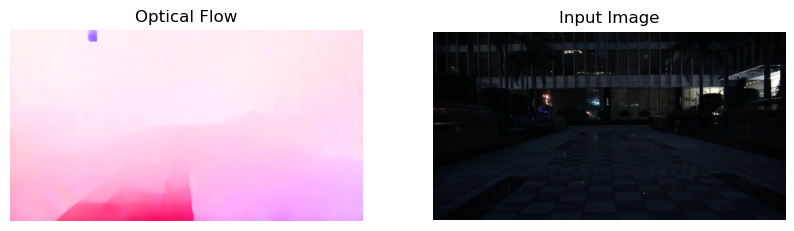

In [11]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# Reading the image
flow_img = mpimg.imread("flow_outputs/0275.png")
input_img = mpimg.imread("datasets/relight/input/pair14/0275.png")

fig, axs = plt.subplots(1, 2, figsize=(10, 5))  # 1 row, 2 columns

# Displaying the image
axs[0].imshow(flow_img)
axs[0].axis('off')  # Hide axis for the first image
axs[0].set_title("Optical Flow")

axs[1].imshow(input_img)
axs[1].axis('off')  # Hide axis for the second image
axs[1].set_title("Input Image")
RelightVDPModule
plt.show()


In [12]:
import pytorch_lightning as pl
trainer = pl.Trainer(
    devices=[0], 
    max_epochs=1,
    benchmark=True,
)
test_outputs = trainer.test(relight_model, datamodule=data_module)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA GeForce RTX 3090') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Testing DataLoader 0: 100%|██████████| 124/124 [00:09<00:00, 13.55it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        gamma_inv           0.8888910412788391
          psnr              26.643543243408203
          ssim               0.859412670135498
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


### Quantative Results

In [13]:
val_dataloader = data_module.val_dataloader()
sample = next(iter(val_dataloader))
outputs = relight_model.inference(sample, 0)
outputs.keys()

dict_keys(['input', 'flow', 'reconstructed', 'rgb_output', 'alpha_output'])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


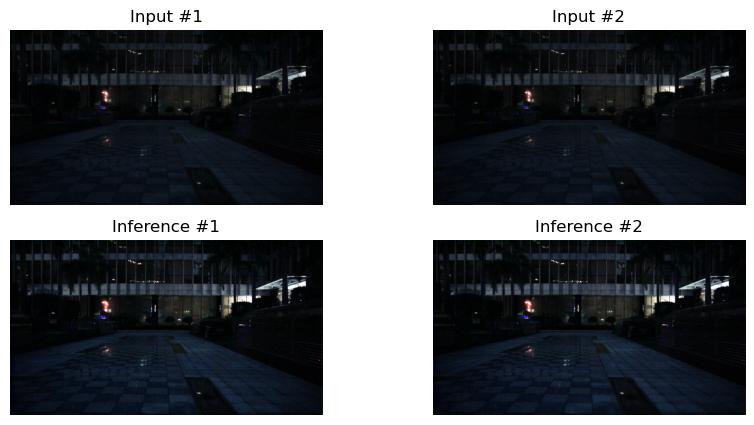

In [14]:
fig, axs = plt.subplots(2, 2, figsize=(10, 5))
    
# Displaying the images
axs[1][0].imshow(outputs["rgb_output"].detach().numpy()[0].transpose(1, 2, 0))
axs[1][0].axis('off')  # Hide axis for the first image
axs[1][0].set_title("Inference #1")  # Setting title for the first image

axs[1][1].imshow(outputs["rgb_output"].detach().numpy()[1].transpose(1, 2, 0))
axs[1][1].axis('off')  # Hide axis for the second image
axs[1][1].set_title("Inference #2")  # Setting title for the second image

# Displaying the images
axs[0][0].imshow(outputs["input"].detach().numpy()[0].transpose(1, 2, 0))
axs[0][0].axis('off')  # Hide axis for the first image
axs[0][0].set_title("Input #1")  # Setting title for the first image

axs[0][1].imshow(outputs["input"].detach().numpy()[1].transpose(1, 2, 0))
axs[0][1].axis('off')  # Hide axis for the second image
axs[0][1].set_title("Input #2")  # Setting title for the second image


plt.show()

### Reproducing Quantative Results

We have written a benchmark file(benchmark_relight.py) for generating the quantative results given in the paper. Since they should be trained for each video, we have not included them in the notebook. However, you can run the benchmark file with the following command:

```bash
python benchmark_relight.py --dataset_path /path/to/dataset
```

For further arguments:
```bash
python benchmark_relight.py --help
```

After benchmarking following results are obtained


Average:
PSNR: 22.65
SSIM: 0.75

Max:
PSNR: 26.64
SSIM: 0.86



## Dehazing

### Hyperparameters

In the following cell you can find the hyperparameters that we use for dehazing. Loss weights are given for reconstruction loss and warp loss with the order.

In [15]:
learning_rate=2e-3
loss_weights=[1, .02]
milestones=[5, 15, 45, 75]
gamma=.5
warmup=True
batch_size=2
num_workers=4
max_epochs=10
devices=[0]
logger='tb'
flow_model='raft'
early_stopping=True
input_path="datasets/dehaze/hazy/W002"
target_path="datasets/dehaze/gt/W002"
airlight_est_path="datasets/dehaze/processed/W002"
flow_path="flow_outputs"

### Training the model

First, one should create the DataModule, which will ultimately handle the generation of optical flow values, creating the dataset, respective data loaders for training, validation and test. The DataModule is created by passing the path to the dataset, batch size, and the number of frames to consider in the optical flow calculation.

- `input_path` is a folder (or a video) that contains the frames of the video that are taken under the bad lighting conditions.
- `target_path` is a folder (or a video) that contains the frames of the video that are taken under the good lighting conditions.
- `flow_path` is the folder that we will be creating/using to store the optical flow values.
- `airlight_path` is the folder that contains the airlight values for the dataset.

**Important Note:** The airlight values are calculated using the code in the following repository: [Dehazing-Airlight-estimation](https://github.com/iamkucuk/Dehazing-Airlight-estimation) Please refer to it for more information.

Rest of the parameters are self-explanatory.

In [16]:
from video_dip.data.datamodule import VideoDIPDataModule
from video_dip.models.optical_flow import RAFT, RAFTModelSize, Farneback

# Initialize the data module
dehaze_data_module = VideoDIPDataModule(
    input_path=input_path, 
    target_path=target_path,
    flow_path=flow_path,
    batch_size=batch_size, 
    num_workers=num_workers,
    airlight_est_path=airlight_est_path
)

Now, we need to generate optical flows with the desired model. For this, we can use the `dump_optical_flow` method. This function will generate the optical flows, with the desired method of user's choosing, for the dataset and save them in the desired directory.

In [17]:
if flow_model == 'raft':
    data_module.dump_optical_flow(flow_model=RAFT(RAFTModelSize.LARGE))
elif flow_model == 'farneback':
    data_module.dump_optical_flow(flow_model=Farneback())
else:
    raise ValueError(f"Invalid flow model: {flow_model}")

100%|██████████| 249/249 [00:55<00:00,  4.46it/s]


Now, one should create the respective model with the desired hyperparameters.

- `learning_rate` is the learning rate of the model.
- `loss_weights` is an iterable that contains the weights for the reconstruction loss and the warp loss, respectively.
- `multi_step_scheduling_kwargs` is a dictionary that contains the milestones and the gamma values for the learning rate scheduler.
    - `milestones` is a list of epochs where the learning rate will be divided by the gamma value.
    - `gamma` is the value that the learning rate will be divided by at the milestones.
- `warmup` is the desire to use warmup or not. If True, a 5-epoch warmup will be applied, which starts from 2e-5 and ends at the desired learning rate.

In [18]:
from video_dip.models.modules.dehaze import DehazeVDPModule

dehaze_model = DehazeVDPModule(
    learning_rate=learning_rate, 
    loss_weights=loss_weights,
    multi_step_scheduling_kwargs={
        'milestones': milestones,
        'gamma': gamma,
    },
    warmup=warmup
)

Now, we can define our custom and pytorch lightning loggers and callbacks for our training loop. Please refer to https://lightning.ai/docs/pytorch/stable/extensions/callbacks.html for more information on callbacks, and https://lightning.ai/docs/pytorch/stable/extensions/logging.html for more information on loggers. 

We are also using a custom-implemented callback for image logging to the desired logger.


In [19]:
from pytorch_lightning.loggers import TensorBoardLogger, WandbLogger
from video_dip.callbacks.image_logger import ImageLogger
from pytorch_lightning.callbacks import LearningRateMonitor

# Initialize the loggers
if logger == 'tb':
    logger = TensorBoardLogger("tb_logs", name=f"video_dip_dehaze_{input_path.split('/')[-1]}")
elif logger == 'wandb':
    logger = WandbLogger(project="video_dip_dehazing")
    logger.watch(dehaze_model)
else:
    raise ValueError(f"Invalid logger: {logger}")

callbacks = [
    ImageLogger(num_images=1),
    LearningRateMonitor(logging_interval='epoch')  # Log learning rate at every training step
]

We finished the preparation for the training loop. Now, we can start training the model. Please refer to [pytorch lightning trainer docs](https://lightning.ai/docs/pytorch/stable/common/trainer.html)

In [20]:
import pytorch_lightning as pl

# Initialize the trainer with the logger
trainer = pl.Trainer(
    logger=logger, 
    devices=devices, 
    max_epochs=max_epochs, # change here
    callbacks=callbacks,
    benchmark=True,
)


# Fit the model
trainer.fit(dehaze_model, datamodule=dehaze_data_module)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA GeForce RTX 3090') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name                | Type                              | Params
--------------------------------------------------------------------------
0 | rgb_net             | UNet                              | 1.7 M 
1 | alpha_net           | UNet                              | 1.7 M 
2 | reconstruction_loss | ReconstructionLoss                | 0     
3 | warp_loss           | OpticalFlowWarpLoss               | 0     
4 | ssim           

Epoch 9: 100%|██████████| 17/17 [00:09<00:00,  1.85it/s, v_num=2, train_loss_step=0.111, psnr=19.60, ssim=0.892, train_loss_epoch=0.102] 

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 17/17 [00:09<00:00,  1.84it/s, v_num=2, train_loss_step=0.111, psnr=19.60, ssim=0.892, train_loss_epoch=0.102]


In [21]:
trainer.test(dehaze_model, datamodule=dehaze_data_module)

You are using a CUDA device ('NVIDIA GeForce RTX 3090') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Testing DataLoader 0: 100%|██████████| 17/17 [00:01<00:00, 10.36it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
          psnr               19.56183433532715
          ssim               0.891859233379364
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


[{'psnr': 19.56183433532715, 'ssim': 0.891859233379364}]

After training this call saves the models checkpoints under vide_dip_dehazing

### Loading the Model

In [22]:
from video_dip.models.modules.dehaze import DehazeVDPModule
dehaze_model = DehazeVDPModule.load_from_checkpoint("tb_logs/video_dip_dehaze_W002/version_0/checkpoints/epoch=74-step=675.ckpt", map_location=f"cuda:{devices[0]}" if len(devices) > 0 else 'cpu')
dehaze_model.eval()

DehazeVDPModule(
  (rgb_net): UNet(
    (encoder): Sequential(
      (0): Sequential(
        (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): LeakyReLU(negative_slope=0.2)
      )
      (1): Sequential(
        (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): LeakyReLU(negative_slope=0.2)
      )
      (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (3): Sequential(
        (0): Conv2d(64, 96, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): LeakyReLU(negative_slope=0.2)
      )
      (4): Sequential(
        (0): Conv2d(96, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1)

### Preparing for Inference

In [23]:
from video_dip.data.datamodule import VideoDIPDataModule
from video_dip.models.optical_flow.raft import RAFT, RAFTModelSize


# creates the data module from given paths
data_module = VideoDIPDataModule(
    input_path="datasets/dehaze/hazy/W002",
    target_path="datasets/dehaze/gt/W002",
    flow_path="flow_outputs",
    airlight_est_path="datasets/dehaze/processed/W002",
    batch_size=2, 
    num_workers=8
)

# dumps optical flow for the dataset
data_module.dump_optical_flow(flow_model=RAFT(RAFTModelSize.LARGE))

data_module.setup()

100%|██████████| 35/35 [00:11<00:00,  2.92it/s]


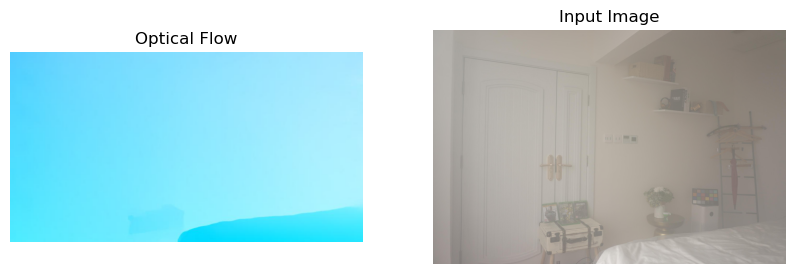

In [24]:

import matplotlib.pyplot as plt
import matplotlib.image as mpimg


# Reading the image
flow_img = mpimg.imread("flow_outputs/00001.JPG")
input_img = mpimg.imread("datasets/dehaze/hazy/W002/00001.JPG")

fig, axs = plt.subplots(1, 2, figsize=(10, 5))  # 1 row, 2 columns

# Displaying the image
axs[0].imshow(flow_img)
axs[0].axis('off')  # Hide axis for the first image
axs[0].set_title("Optical Flow")

axs[1].imshow(input_img)
axs[1].axis('off')  # Hide axis for the second image
axs[1].set_title("Input Image")

plt.show()


In [25]:
import pytorch_lightning as pl
trainer = pl.Trainer(
    devices=[0], 
    max_epochs=1,
    benchmark=True,
)
test_outputs = trainer.test(dehaze_model, datamodule=data_module)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA GeForce RTX 3090') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Testing DataLoader 0: 100%|██████████| 17/17 [00:01<00:00, 11.72it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
          psnr               22.24893569946289
          ssim              0.8942875862121582
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


### Quantative Results

In [26]:
val_dataloader = data_module.val_dataloader()
sample = next(iter(val_dataloader))
outputs = dehaze_model.inference(sample, 0, airlight=sample['airlight'])
outputs.keys()

dict_keys(['input', 'flow', 'reconstructed', 'rgb_output', 'alpha_output'])

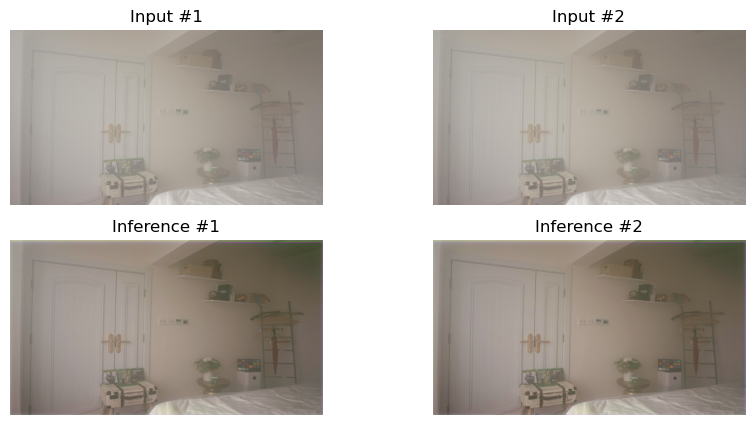

In [27]:
fig, axs = plt.subplots(2, 2, figsize=(10, 5))
    
# Displaying the images
axs[1][0].imshow(outputs["rgb_output"].detach().numpy()[0].transpose(1, 2, 0))
axs[1][0].axis('off')  # Hide axis for the first image
axs[1][0].set_title("Inference #1")  # Setting title for the first image

axs[1][1].imshow(outputs["rgb_output"].detach().numpy()[1].transpose(1, 2, 0))
axs[1][1].axis('off')  # Hide axis for the second image
axs[1][1].set_title("Inference #2")  # Setting title for the second image





# Displaying the images
axs[0][0].imshow(outputs["input"].detach().numpy()[0].transpose(1, 2, 0))
axs[0][0].axis('off')  # Hide axis for the first image
axs[0][0].set_title("Input #1")  # Setting title for the first image

axs[0][1].imshow(outputs["input"].detach().numpy()[1].transpose(1, 2, 0))
axs[0][1].axis('off')  # Hide axis for the second image
axs[0][1].set_title("Input #2")  # Setting title for the second image


plt.show()

### Reproducing Quantative Results

We have written a benchmark file(benchmark_dehaze.py) for generating the quantative results given in the paper. Since they should be trained for each video, we have not included them in the notebook. However, you can run the benchmark file with the following command:

```bash
python benchmark_dehaze.py --dataset_path /path/to/dataset
```

For further arguments:
```bash
python benchmark_dehaze.py --help
```

After benchmarking following results are obrained: 

Average:
PSNR: 15.94
SSIM: 0.77

Max:
PSNR: 22.2
SSIM: 0.89


## Segmentation

### Hyperparameters

In the following cell you can find the hyperparameters that we use for relighting. Loss weights are given for reconstruction loss and warp loss with the order.

In [28]:
learning_rate=2e-3
loss_weights=[.001, 1, 1, .001, .01]
milestones=[5, 15, 45, 75]
gamma=.5
warmup=True
batch_size=2
num_workers=4
max_epochs=1
devices=[0] # Select GPU 0 for training things
logger='tb'
flow_model='raft'
early_stopping=True
input_path="datasets/benchmark_root/input/blackswan"
target_path="datasets/benchmark_root/GT/blackswan"
flow_path="datasets/input/blackswan_flow"






### Training the model

First, one should create the DataModule, which will ultimately handle the generation of optical flow values, creating the dataset, respective data loaders for training, validation and test. The DataModule is created by passing the path to the dataset, batch size, and the number of frames to consider in the optical flow calculation.

- `input_path` is a folder (or a video) that contains the frames of the video that are taken under the bad lighting conditions.
- `target_path` is a folder (or a video) that contains the frames of the video that are taken under the good lighting conditions.
- `flow_path` is the folder that we will be creating/using to store the optical flow values.

Rest of the parameters are self-explanatory.

In [29]:
from video_dip.data.datamodule import VideoDIPDataModule
from video_dip.models.optical_flow import RAFT, RAFTModelSize, Farneback

# Initialize the data module
data_module = VideoDIPDataModule(
    input_path=input_path, 
    target_path=target_path,
    flow_path=flow_path,
    batch_size=batch_size, 
    num_workers=num_workers
)

Now, we need to generate optical flows with the desired model. For this, we can use the `dump_optical_flow` method. This function will generate the optical flows, with the desired method of user's choosing, for the dataset and save them in the desired directory.

In [30]:
if flow_model == 'raft':
    data_module.dump_optical_flow(flow_model=RAFT(RAFTModelSize.LARGE))
elif flow_model == 'farneback':
    data_module.dump_optical_flow(flow_model=Farneback())
else:
    raise ValueError(f"Invalid flow model: {flow_model}")

100%|██████████| 49/49 [00:11<00:00,  4.32it/s]


Now, one should create the respective model with the desired hyperparameters.

- `learning_rate` is the learning rate of the model.
- `loss_weights` is an iterable that contains the weights for the reconstruction loss and the warp loss, respectively.
- `multi_step_scheduling_kwargs` is a dictionary that contains the milestones and the gamma values for the learning rate scheduler.
    - `milestones` is a list of epochs where the learning rate will be divided by the gamma value.
    - `gamma` is the value that the learning rate will be divided by at the milestones.
- `warmup` is the desire to use warmup or not. If True, a 5-epoch warmup will be applied, which starts from 2e-5 and ends at the desired learning rate.

In [31]:
from video_dip.models.modules.segmentation import SegmentationVDPModule

model = SegmentationVDPModule(
    learning_rate=learning_rate, 
    loss_weights=loss_weights,
    multi_step_scheduling_kwargs={
        'milestones': milestones,
        'gamma': gamma,
    },
    warmup=warmup
)

Now, we can define our custom and pytorch lightning loggers and callbacks for our training loop. Please refer to https://lightning.ai/docs/pytorch/stable/extensions/callbacks.html for more information on callbacks, and https://lightning.ai/docs/pytorch/stable/extensions/logging.html for more information on loggers. 

We are also using a custom-implemented callback for image logging to the desired logger.


In [32]:
from pytorch_lightning.loggers import TensorBoardLogger, WandbLogger
from video_dip.callbacks.image_logger import ImageLogger
from pytorch_lightning.callbacks import LearningRateMonitor

# Initialize the loggers
if logger == 'tb':
    logger = TensorBoardLogger("tb_logs",  name=f"video_dip_degmentation_{input_path.split('/')[-1]}")
elif logger == 'wandb':
    logger = WandbLogger(project="video_dip_segmentation")
    logger.watch(model)
else:
    raise ValueError(f"Invalid logger: {logger}")

callbacks = [
    ImageLogger(num_images=1),
    LearningRateMonitor(logging_interval='epoch')  # Log learning rate at every training step
]

We finished the preparation for the training loop. Now, we can start training the model. Please refer to [pytorch lightning trainer docs](https://lightning.ai/docs/pytorch/stable/common/trainer.html)

In [33]:
import pytorch_lightning as pl

# Initialize the trainer with the logger
trainer = pl.Trainer(
    logger=logger, 
    devices=devices, 
    max_epochs=max_epochs,  # change here
    callbacks=callbacks,
    benchmark=True,
)


# Fit the model
trainer.fit(model, datamodule=data_module)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA GeForce RTX 3090') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name                 | Type                    | Params
-----------------------------------------------------------------
0 | rgb_net              | UNet                    | 1.7 M 
1 | alpha_net            | UNet                    | 1.7 M 
2 | reconstruction_loss  | ReconstructionLoss      | 0     
3 | warp_loss            | OpticalFlowWarpLoss     | 0     
4 | rgb_net2             | UNet                    | 1.7 M 
5 | flow_simi

Epoch 0: 100%|██████████| 24/24 [00:16<00:00,  1.41it/s, v_num=2, iou_score=0.0996, train_loss=0.923]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 24/24 [00:17<00:00,  1.40it/s, v_num=2, iou_score=0.0996, train_loss=0.923]


We can now track the progress of our training either with tensorboard or wandb. You can find more information about the training loop at the training loop prints.

After we are done with the training, we can evaluate the model with the test dataset. We can use the `test` method for this purpose. The datamodule named `data_module` already has the test data, and it's respective dataloader (same data as the data we use for our training). So, we can use the same data module for testing. 

In [34]:
trainer.test(model, datamodule=data_module)

You are using a CUDA device ('NVIDIA GeForce RTX 3090') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Testing DataLoader 0: 100%|██████████| 24/24 [00:02<00:00,  9.02it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        iou_score           0.09963411092758179
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


[{'iou_score': 0.09963411092758179}]

### Loading the Model

After training this call saves the models checkpoints under vide_dip_dehazing

In [35]:
from video_dip.models.modules.segmentation import SegmentationVDPModule
segmentation_model = SegmentationVDPModule.load_from_checkpoint("segmentation_checkpoints/blackswan/segmentation_epoch=28-step=1160.ckpt", map_location=f"cuda:{devices[0]}" if len(devices) > 0 else 'cpu')
segmentation_model.eval()




SegmentationVDPModule(
  (rgb_net): UNet(
    (encoder): Sequential(
      (0): Sequential(
        (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): LeakyReLU(negative_slope=0.2)
      )
      (1): Sequential(
        (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): LeakyReLU(negative_slope=0.2)
      )
      (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (3): Sequential(
        (0): Conv2d(64, 96, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): LeakyReLU(negative_slope=0.2)
      )
      (4): Sequential(
        (0): Conv2d(96, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
     

### Preparing for Inference

In [36]:
from video_dip.data.datamodule import VideoDIPDataModule
from video_dip.models.optical_flow.raft import RAFT, RAFTModelSize


# creates the data module from given paths
data_module = VideoDIPDataModule(
    input_path="datasets/benchmark_root/input/blackswan",
    target_path="datasets/benchmark_root/GT/blackswan",
    flow_path="datasets/input/blackswan_flow",
    batch_size=2, 
    num_workers=8
)

# dumps optical flow for the dataset
data_module.dump_optical_flow(flow_model=RAFT(RAFTModelSize.LARGE))


data_module.setup()

100%|██████████| 49/49 [00:11<00:00,  4.30it/s]


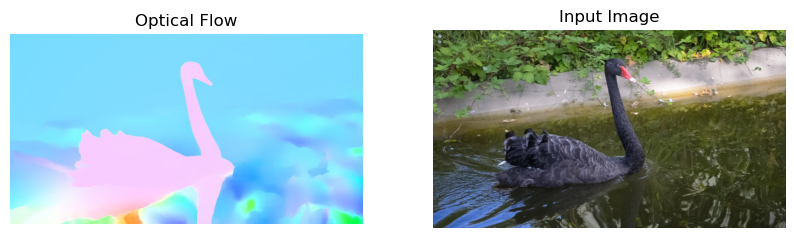

In [37]:

import matplotlib.pyplot as plt
import matplotlib.image as mpimg


# Reading the image
flow_img = mpimg.imread("datasets/input/blackswan_flow/00001.jpg")
input_img = mpimg.imread("datasets/benchmark_root/input/blackswan/00001.jpg")

fig, axs = plt.subplots(1, 2, figsize=(10, 5))  # 1 row, 2 columns

# Displaying the image
axs[0].imshow(flow_img)
axs[0].axis('off')  # Hide axis for the first image
axs[0].set_title("Optical Flow")

axs[1].imshow(input_img)
axs[1].axis('off')  # Hide axis for the second image
axs[1].set_title("Input Image")

plt.show()


In [38]:
import pytorch_lightning as pl
trainer = pl.Trainer(
    devices=[0], 
    max_epochs=1,
    benchmark=True,
)
test_outputs = trainer.test(segmentation_model, datamodule=data_module)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA GeForce RTX 3090') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Testing DataLoader 0: 100%|██████████| 24/24 [00:02<00:00,  8.86it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        iou_score          0.019319312646985054
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


### Quantative Results

In [39]:
val_dataloader = data_module.val_dataloader()
sample = next(iter(val_dataloader))
outputs = segmentation_model.inference(sample, 0)
outputs.keys()

dict_keys(['input', 'flow', 'flow_rgb', 'reconstructed', 'rgb_output', 'rgb_output2', 'alpha_output'])

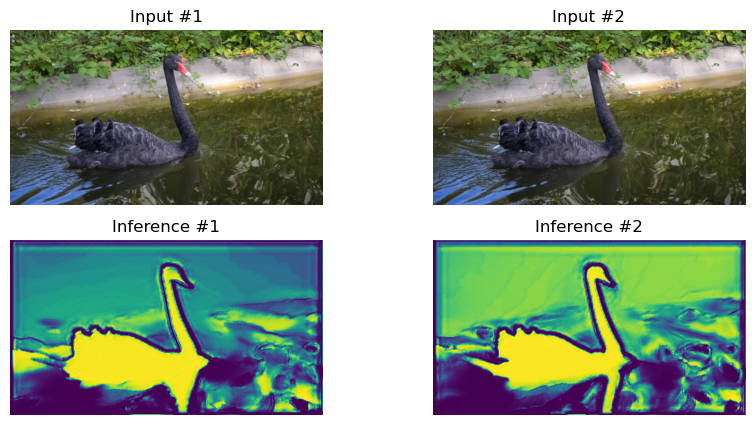

In [40]:
fig, axs = plt.subplots(2, 2, figsize=(10, 5))
    
# Displaying the images
axs[1][0].imshow(outputs["alpha_output"].detach().numpy()[0].transpose(1, 2, 0))
axs[1][0].axis('off')  # Hide axis for the first image
axs[1][0].set_title("Inference #1")  # Setting title for the first image

axs[1][1].imshow(outputs["alpha_output"].detach().numpy()[1].transpose(1, 2, 0))
axs[1][1].axis('off')  # Hide axis for the second image
axs[1][1].set_title("Inference #2")  # Setting title for the second image





# Displaying the images
axs[0][0].imshow(outputs["input"].detach().numpy()[0].transpose(1, 2, 0))
axs[0][0].axis('off')  # Hide axis for the first image
axs[0][0].set_title("Input #1")  # Setting title for the first image

axs[0][1].imshow(outputs["input"].detach().numpy()[1].transpose(1, 2, 0))
axs[0][1].axis('off')  # Hide axis for the second image
axs[0][1].set_title("Input #2")  # Setting title for the second image


plt.show()

### Reproducing Quantative Results

We have written a benchmark file(benchmark_segmentation.py) for generating the quantative results given in the paper. 

In [41]:
import os
#os.system("python benchmark_dehaze.py")

Unfortunately we could not run benchmark on segmentation task. We have done >100 experiments troughout the development for segmentation but when we run the benchmark script our computer crashed with some I/O error(not related to our developments). We will give multiple wandb links so that you can go over our experiments



# Challanges



**Flow Estimate in Low Light Setting**





The model, as demonstrated in the paper, requires the following input. In contrast, the input obtained from videos captured in extremely low light conditions is shown below:

<center>
    <figure>
        <img src="figures/paper_flow.png" alt="Paper Flow" title="Paper Flow" width="40%">
        <img src="figures/lowlight_flow.png" alt="Low Light Flow" title="Low Light Flow" width="40%">
        <figcaption>Challenge: Flow Estimate in Low Light Setting,Paper Flow on the left, Low Light Flow on the right  </figcaption>
    </figure>
</center>


The input from these low light videos lacks visible information, significantly impairing the performance of the alpha network.

**Gamma Inverse Effect**


Paper states that gamma inverse is converging in every training. We saw that, results are highly sensitive to initial gamma inverse value.

<center>
    <figure>
        <img src="figures/gamma_inv.png" alt="Gamma Inverse Effect" title="Gamma Inverse Effect" width="80%">
        <figcaption>Challenge: Gamma Inverse Effect  </figcaption>
    </figure>
</center>



**Scarcity of Training Details**

The paper provides minimal training details, making it extremely challenging and laborious to achieve or approach the desired metrics. Additionally, it appears that the choice of hyper-parameters significantly impacts each video individually. With that, the training process becomes more complex and time-consuming, which also involves extensive hyper-parameter tuning to obtain best results for each video.


**Alpha-net Outputs in Segmentation**

Paper mentions that reconstruction loss is not enough to realize segmentation therefore additional losses are implemented. However in our experiments we observed that reconstruction is learned before alpha-net is able to produce sensible predictions. That is problematic because reconstruction depends on alpha-maps and first alpha-maps are not sensible, reconstruction is learned with wrong alpha maps. After a certain point alpha-net cannot recover from that point. 


<center>
    <figure>
        <img src="figures/segmentation_map_bad.png" alt="Segmentation Map 21st step" title="Segmentation Map 21st step" width="40%">
        <img src="figures/segmentation_map_good.png" alt="Segmentation Map 24th step" title="Segmentation Map 24th step" width="40%">
        <figcaption>Challenge: Alpha net outputs are not good because of the reconstruction is prioritized  </figcaption>
    </figure>
</center>


At this point reconstruction is very well as follows:


<center>
    <figure>
        <img src="figures/blackswan_reconstruction.png" alt="Reconstruction of Input Image" title="Reconstruction of Input Image" width="80%">
        <figcaption>Reconstruction when alpha net outputs are not good</figcaption>
    </figure>
</center>


This problem is especially visible when multiple trainins are run with different initialization points. Each of these training runs produce highly different models. 

You can see different runs in following wandb reports

* [Wandb Report](https://api.wandb.ai/links/alperbah-13/671770ca)
* [Wandb Report](https://api.wandb.ai/links/alperbah-13/xbiwd0uz)
* [Wandb Report](https://api.wandb.ai/links/alperbah-13/y4dhsuqd)
* [Wandb Report](https://api.wandb.ai/links/alperbah-13/cuk8g8v8)



You can also see experiment results for dehazing and relighting experiments using tensorboard.

Just run the following command in the terminal:

```bash
tensorboard --logdir=tb_logs
```

# Conclusion and Final Thoughts

In this notebook, we have implemented the Video Decomposition Prior framework proposed in the paper "Video Decomposition Prior: Editing Videos Layer by Layer". We have implemented the three downstream tasks of the paper, namely Video Relighting, Video Dehazing, and Unsupervised Video Object Segmentation. We have also discussed the challenges we faced during the implementation and the results we obtained.

The Video Decomposition Prior framework is a not-so-novel approach to video editing that allows for the manipulation of videos without the need for supervision. The framework is based on the idea of decomposing videos into multiple layers and editing them individually. The framework has shown promising results in the three downstream tasks, however, each training is incredibly sensitive to hyperparameters and initialization points, which requires extensive tuning per video. Besides that, the scarcity of training details in the paper makes it challenging to achieve the desired results. Furthermore, the framework is not robust enough to handle videos captured in extremely low light conditions, which hinders the capability of capturing details within the optical flow. It might not seem so obvious, but we need some kind of high level details too, in order to capture the real motion of every part of a frame. Without it, we will be relying too much on the RGBNet to capture the desired output, which obviously defies the main idea of the paper.